<a href="https://colab.research.google.com/github/leticiaplang/drug_classification/blob/main/drug_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

* It has 200 rows and 6 columns
* The target feature is Drug type (a, b, c, x, y)
* The feature sets are: 

    Age: 15 - 74 years

    Sex: F(female), M(male)

    Blood Pressure Levels (BP): normal, low, high

    Cholesterol Levels: normal, high 
    * Blood exam

  Na to Potassium Ratio: 6.269 - 38.247
  * Urinary exam | A high ratio is an indicator of a higher Na intake and a lower K intake.

* The goal is predict which drug will be used based on features. 

[Kaggle Dataset](https://www.kaggle.com/prathamtripathi/drug-classification)

## Preparing the notebook

In [ ]:
# install
!pip install imbalanced-learn

In [ ]:
# Imports
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from scipy import stats

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

In [ ]:
# Acessing the document by google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Creatibg the dataframe
df = pd.read_csv('drive/MyDrive/a/drug200.csv', sep = ',')

In [ ]:
# Checking the DF
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


## Exploratory Analysis

### Verifying the dataset

In [ ]:
# DF rows and columns
df.shape

(200, 6)

In [ ]:
# Types & null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [ ]:
# Duplicated data
df.duplicated().sum()

0

In [ ]:
# Responses by columns 
df['BP'].unique()

array(['HIGH', 'LOW', 'NORMAL'], dtype=object)

In [ ]:
df['Cholesterol'].unique()

array(['HIGH', 'NORMAL'], dtype=object)

In [ ]:
df['Drug'].unique()

array(['DrugY', 'drugC', 'drugX', 'drugA', 'drugB'], dtype=object)

In [ ]:
# Basic statistics
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


### Variables

Categorical: Sex, BP(blood pressure), Cholesterol, Drug

Continuous: Age, Na_to_K

### Transformations

#### Lowercase strings

In [ ]:
# Columns name
df.columns = df.columns.str.lower()

In [ ]:
# Columns data
col = ['sex', 'bp', 'cholesterol', 'drug']

In [ ]:
# Lowercase transformation
for n in col:
  df[n] = df[n].apply(lambda x: x.lower())

In [ ]:
# Drug essencial information
df['drug'] = [n[-1] for n in df['drug']]

In [ ]:
df.head()

,age,sex,bp,cholesterol,na_to_k,drug
0,23,f,high,high,25.355,y
1,47,m,low,high,13.093,c
2,47,m,low,high,10.114,c
3,28,f,normal,high,7.798,x
4,61,f,low,high,18.043,y


### Distribution & Balance

* Imbalance categorical data
* Age - more similar to a symmetrical distribution
* Na to K - positive skewness | outliers seems be associated with Dug Y

In [ ]:
continuous_var = ['age', 'na_to_k']
categorical_var = ['sex', 'bp', 'cholesterol', 'drug']

##### Countinous variables

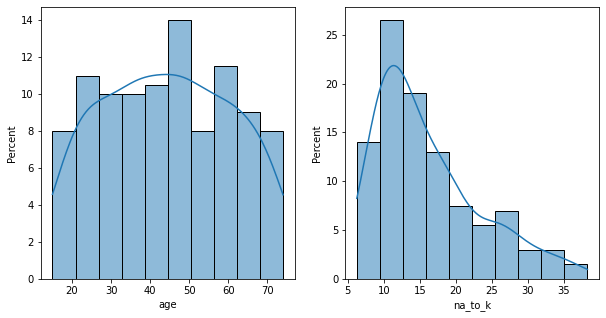

In [ ]:
# General distribution | histogram for which variable
n_rows=1
n_cols=2

## Creating subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_size_inches(10, 5)

## Creating histograms
for i, column in enumerate(continuous_var):
  sns.histplot(df[column], ax=axes[i%n_cols], bins=10,  stat="percent", kde=True)

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


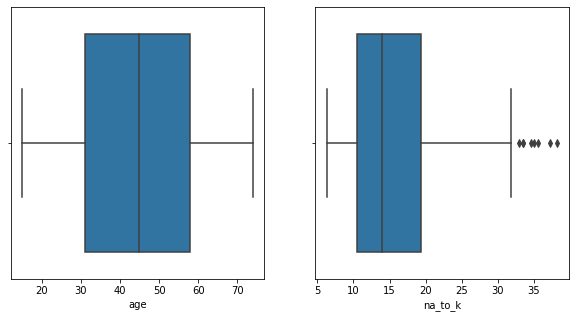

In [ ]:
# General distribution | boxplot for which variable
n_rows=1
n_cols=2

## Creating subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_size_inches(10, 5)

## Creating boxplot
for i, column in enumerate(continuous_var):
  sns.boxplot(df[column], ax=axes[i%n_cols])

plt.show()

#### Analysing outliers
* It seems association with drug y

In [ ]:
# analysing outliers > high na_to_k == drug Y(?)
def outliers(df,col):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  return df[((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]

In [ ]:
outliers(df, 'na_to_k')

,age,sex,bp,cholesterol,na_to_k,drug
24,33,f,low,high,33.486,y
96,58,f,low,high,38.247,y
98,20,m,high,normal,35.639,y
128,47,m,low,normal,33.542,y
131,52,m,low,normal,32.922,y
184,18,f,high,high,37.188,y
188,65,m,high,normal,34.997,y
194,46,f,high,high,34.686,y


#### Categorical variables

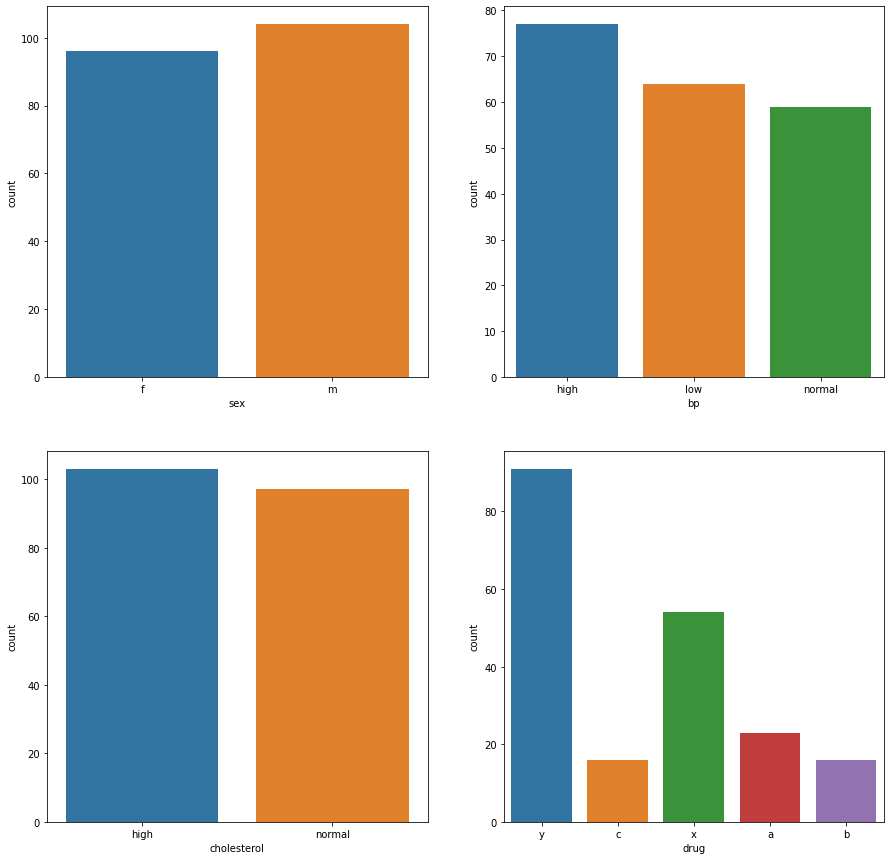

In [ ]:
# General distribution | countplot for which variable
n_rows=2
n_cols=2
warnings.filterwarnings("ignore")

## Creating subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_size_inches(15, 15)

## Creating boxplot
for i, column in enumerate(categorical_var):
  sns.countplot(df[column], ax=axes[i//n_cols,i%n_cols])

plt.show()

### Insights

#### Association between features and target
              || Drug A | Drug B | Drug C | Drug X | Drug Y |

      |  Age  ||  < 50  |  > 50  |        |        |        |
      |  Sex  ||        |        |        |        |        |
      |  BP   ||  high  |  high  |  low   |norm/low|        |
      |  Chol ||        |        |  high  |        |        |
      |  Na_K ||  < 15  |  < 15  |  < 15  |  < 15  |  > 15  |


In [ ]:
### FAZER BOXPLOT, violino
cont_feature = ['age', 'na_to_k']
cat_feature = ['sex', 'bp', 'cholesterol']


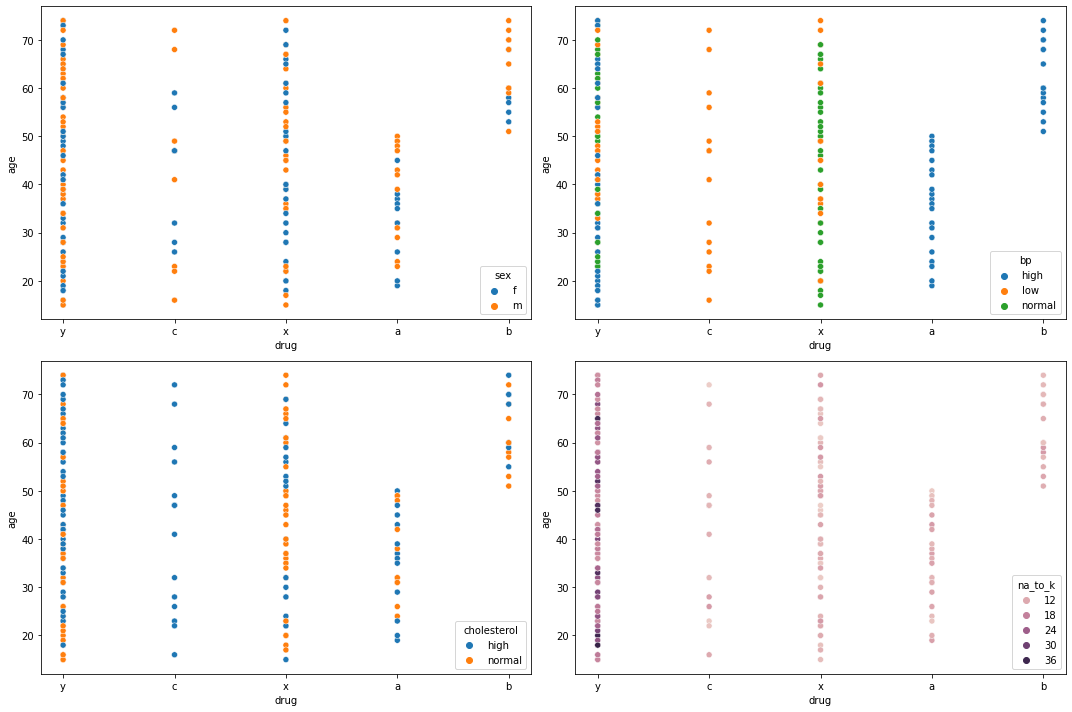

In [ ]:
# Analysing target and age with others variables
n_rows=2
n_cols=2

## Subplots
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_size_inches(15, 10)

X = 'drug'
Y = 'age'
H = ['sex', 'bp', 'cholesterol', 'na_to_k']

for i, H in enumerate(df[H]):
  sns.scatterplot(x=X, y=Y, hue=H, data=df, ax=axs[i//n_cols,i%n_cols])

plt.tight_layout()
plt.show()

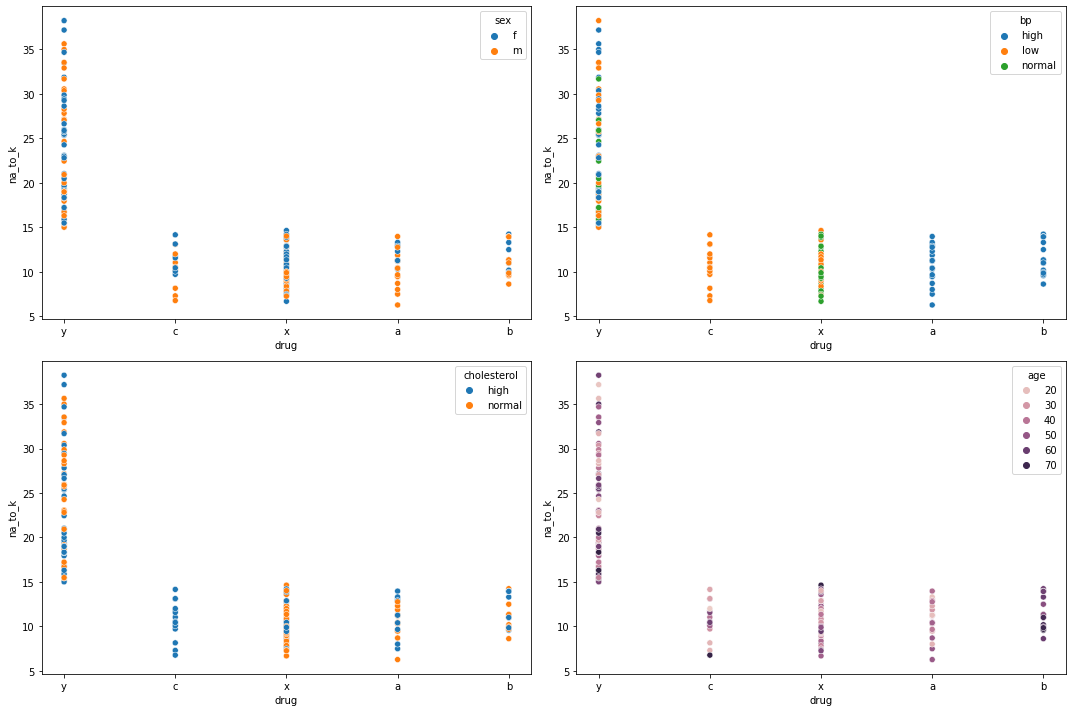

In [ ]:
# Analysing target and na_to_k with others variables
n_rows=2
n_cols=2

## Subplots
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_size_inches(15, 10)

X = 'drug'
Y = 'na_to_k'
H = ['sex', 'bp', 'cholesterol', 'age']

for i, H in enumerate(df[H]):
  sns.scatterplot(x=X, y=Y, hue=H, data=df, ax=axs[i//n_cols,i%n_cols])

plt.tight_layout()
plt.show()

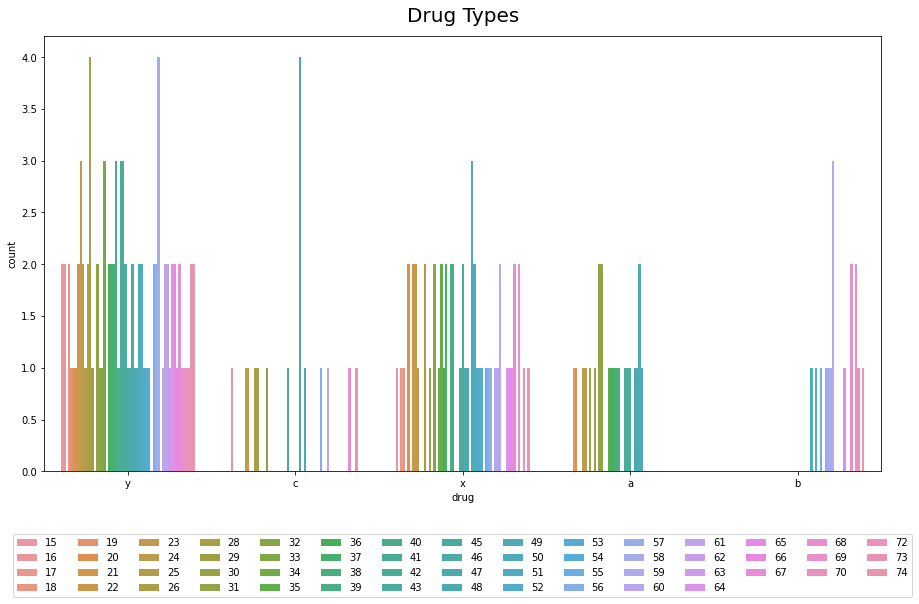

In [ ]:
# Age frequency / drug type
plt.figure(figsize=(15,8))
plt.title("Drug Types", fontsize=20, y=1.02)
sns.countplot(hue = df.age, x = df.drug)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=15)
plt.show()

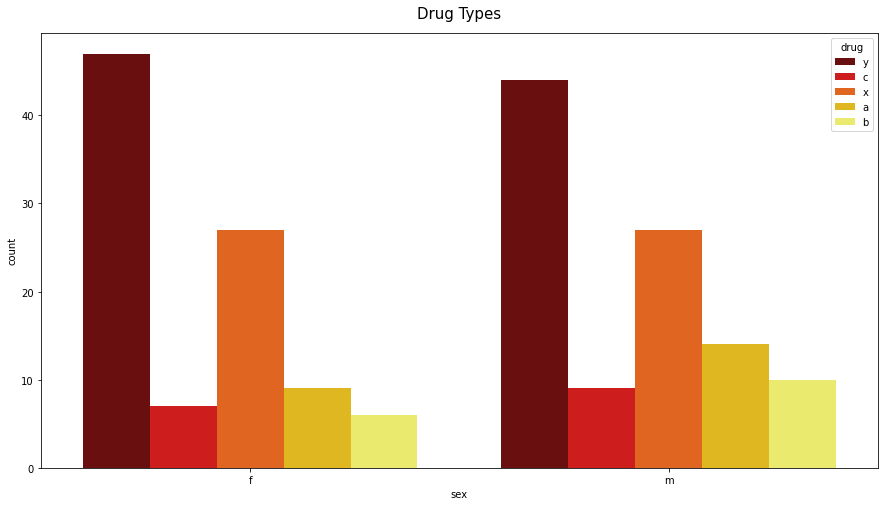

In [ ]:
# Sex frequency / drug type
plt.figure(figsize=(15,8))
plt.title("Drug Types", fontsize=15, y=1.02)
sns.countplot(x = df.sex, hue = df.drug, palette="hot")
plt.show()

## Algorithm
* The insights couldn't define at all which drug will be used based on features.
* This is a classification problem which has as:
  * Target: Drug
  * Continuous features: Age and Na_to_K
  * Categorical features: Sex, Bp, Cholesterol

#### Feature engineering

* Transforming target and caterogical features with label enconder
        |  sex  |  drug  |   bp   | cholesterol |
      0 |   f   |    a   |  low   |    normal   |
      1 |   m   |    b   | normal |     high    |
      2 |       |    c   |  high  |
      3 |       |    x   |
      4 |       |    y   |

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Label enconding

## Variables
le = LabelEncoder()
bp = ['low', 'normal', 'high'] #To define the label order
chol = ['normal', 'high'] #To define the label order


## Fit transform | columns sex & drug
for c in ['sex', 'drug']:
  df[c] = le.fit_transform(df[c])
  
## fit transform | column blood pressure
le.fit(df['bp'])
le.classes_ = np.array(bp) #Specifying the label order
df['bp'] = le.transform(df['bp'])

## fit transform | column cholesterol
le.fit(df['cholesterol'])
le.classes_ = np.array(chol) #Specifying the label order
df['cholesterol'] = le.transform(df['cholesterol'])


In [ ]:
df.head()

,age,sex,bp,cholesterol,na_to_k,drug
0,23,0,2,1,25.355,4
1,47,1,0,1,13.093,2
2,47,1,0,1,10.114,2
3,28,0,1,1,7.798,3
4,61,0,0,1,18.043,4


### Defining the functions

In [ ]:
def create_scenarios(features, scalling, outlier, rebalance, algorithm):
  ''' It combines de list of strings from variables to create 
  differents scenarios to run de model.
  Input: variables separated by coma. Each variable contains a list of strings.
        if there are no situation in some variable, insert 'none'. 
  Output: a variable called 'scenarios' which contains a list of dictionary. '''

  # Creating scenarios/combinations
  global scenarios 
  scenarios = []
  for f in features:
    for o in outlier:
      for s in scalling:
        for r in rebalance:
          for a in algorithm:
              scenario = {'features': f,
                          'outlier': o, 
                          'scalling': s,
                          'rebalance': r,
                          'algorithm': a,
                          }
              scenarios.append(scenario)
  print(f'There are {len(scenarios)} possible scenarios.')

In [102]:
## Defining dataset function
def run_model(df, scenario, target):
  '''
  Function to run the selected scenario.
  Input: dataframe,
         variable 'scenario'
  Output: return the scenario analysed and the metrics.
  '''
  results = []

  # Running each scenario
  for n in range(5000):  
    if scenario['features'] == 'all':
      dft = df

    ## Split train & test0
    X = dft.drop(columns = target)
    y = dft[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    ## outlier
    if scenario['outlier'] == 'none':
      pass

    ## scalling  
    if scenario['scalling'] == 'none':
      pass

    ## rebalance
    if scenario['rebalance'] == 'none':
      pass
    ## algorithm
    if scenario['algorithm'] == 'dummie':
      model = DummyClassifier()
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
    elif scenario['algorithm'] == 'logistic':
      model = LogisticRegression() 
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
    elif scenario['algorithm'] == 'knn':
      model = KNeighborsClassifier()
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
    elif scenario['algorithm'] == 'tree_clas':
      model = DecisionTreeClassifier()
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
    elif scenario['algorithm'] == 'random':
      model = RandomForestClassifier()
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

    ## Metrics & append
    results.append({'Accuracy': accuracy_score(y_test, y_pred), 
                    'Precision': precision_score(y_test, y_pred, average='weighted'),
                    'Recall:': recall_score(y_test, y_pred, average='weighted'),
                    'F1-score:': f1_score(y_test, y_pred, average='weighted')})
  return results


In [103]:
# Defining variables
features = ['all']
outlier = ['none']
scalling = ['none']
rebalance = ['none']
algorithm = ['dummie', 'logistic', 'knn', 'tree_clas']
target = ['drug']

In [104]:
create_scenarios(features, scalling, outlier, rebalance, algorithm)

There are 4 possible scenarios.


### Testing the scenarios

{'features': 'all', 'outlier': 'none', 'scalling': 'none', 'rebalance': 'none', 'algorithm': 'dummie'}


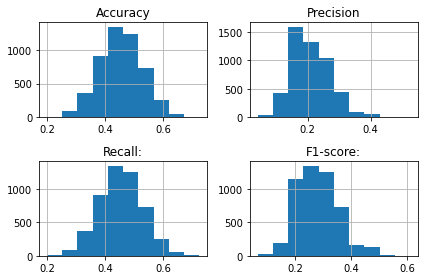

In [105]:
# Scenario // BASELINE
scenario = scenarios[0]
print(scenario)
# Runnig the model
warnings.filterwarnings("ignore")
scen_0 = pd.DataFrame(run_model(df, scenario, target))
# Ploting a histogram to analyse the medium value
scen_0.hist()
plt.tight_layout()

{'features': 'all', 'outlier': 'none', 'scalling': 'none', 'rebalance': 'none', 'algorithm': 'logistic'}


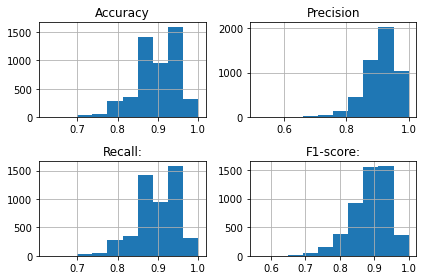

In [81]:
scenario = scenarios[1]
print(scenario)
warnings.filterwarnings("ignore")
scen_1 = pd.DataFrame(run_model(df, scenario, target))
scen_1.hist()
plt.tight_layout()

{'features': 'all', 'outlier': 'none', 'scalling': 'none', 'rebalance': 'none', 'algorithm': 'knn'}


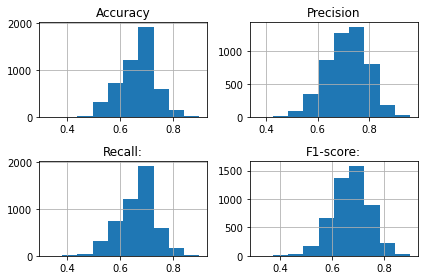

In [82]:
scenario = scenarios[2]
print(scenario)
warnings.filterwarnings("ignore")
scen_2 = pd.DataFrame(run_model(df, scenario, target))
scen_2.hist()
plt.tight_layout()

{'features': 'all', 'outlier': 'none', 'scalling': 'none', 'rebalance': 'none', 'algorithm': 'tree_clas'}


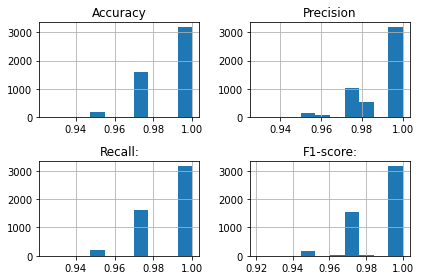

In [83]:
scenario = scenarios[3]
print(scenario)
warnings.filterwarnings("ignore")
scen_3 = pd.DataFrame(run_model(df, scenario, target))
scen_3.hist()
plt.tight_layout()

## Conclusion
* The best model performance was with the logistic regression
* The model predict correctly 89% of the sample
* It identifies less false positives(precision) and a little more of false negatives (recall)
* To improve the model, it's importante colect more data or use resample transformations 

In [74]:
scen_1.mean()

Accuracy     0.890905
Precision    0.906576
Recall:      0.890905
F1-score:    0.888947
dtype: float64